# Training pipeline

Creating a model to predict premier league player score with previous created feature group

# Imports

In [272]:
# imports
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from importlib import reload

from functions import util

import warnings
warnings.filterwarnings("ignore")

## Connect to Hopsworks feature store

In [273]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
with open('./hopsworks/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
print(project.description)

2025-01-07 12:18:13,037 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 12:18:13,039 INFO: Initializing external client
2025-01-07 12:18:13,040 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 12:18:14,313 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321
Default project


In [274]:
fs = project.get_feature_store()

# Retrieve feature group
player_fg = fs.get_feature_group(
    name='player_features',
    version=1,
)

# Create feature view

In [275]:
# Select features
selected_features = player_fg.select_all()
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


,id,points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,prev_total_points,prev_selected,prev_transfers_balance,prev_value,prev_was_home
0,410,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,7.0,80260.0,-6825.0,49.0,0.0
1,208,0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,44464.0,-2649.0,44.0,0.0
2,184,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,5.0,22095.0,-1359.0,45.0,1.0
3,340,0,13,90.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.08,0.03,0.11,2.51,0.0,22.0,425265.0,-44894.0,54.0,1.0
4,388,2,4,90.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.00,0.05,0.05,3.00,0.0,2.0,176074.0,-10731.0,45.0,1.0
5,327,1,14,90.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.00,0.11,0.11,0.77,0.0,71.0,2222600.0,-305131.0,76.0,1.0
6,377,2,16,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.01,0.01,0.00,0.0,10.0,45753.0,680.0,49.0,1.0
7,586,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,5565.0,-730.0,45.0,1.0
8,482,1,10,86.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.09,0.09,0.83,0.0,23.0,45810.0,9205.0,49.0,0.0
9,556,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,171186.0,4616.0,40.0,0.0


In [276]:
# Create feature view
feature_view = fs.get_or_create_feature_view(
    name='player_score_fv',
    description="player data with score label",
    version=1,
    labels=['points'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1159321/fs/1150024/fv/player_score_fv/version/1


# Split data into training and test set

In [277]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


In [278]:
X_train

,id,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,prev_penalties_missed,...,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,prev_total_points,prev_selected,prev_transfers_balance,prev_value,prev_was_home
1,208,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,44464.0,-2649.0,44.0,0.0
2,184,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,5.0,22095.0,-1359.0,45.0,1.0
3,340,13,90.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.08,0.03,0.11,2.51,0.0,22.0,425265.0,-44894.0,54.0,1.0
5,327,14,90.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.11,0.11,0.77,0.0,71.0,2222600.0,-305131.0,76.0,1.0
6,377,16,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.01,0.01,0.00,0.0,10.0,45753.0,680.0,49.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8174,364,14,90.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.14,0.09,0.23,0.65,0.0,46.0,389439.0,61225.0,49.0,1.0
8175,198,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,3.0,45640.0,-18769.0,54.0,0.0
8177,162,16,90.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.19,0.01,0.20,2.90,0.0,33.0,438223.0,-6586.0,45.0,0.0
8180,50,2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,1.04,0.0,1.0,26790.0,0.0,40.0,0.0


In [279]:
# Drop the index columns - 'id' (event_time) and 'gameweek' (primary key)

train_features = X_train.drop(['id', 'gameweek'], axis=1)
test_features = X_test.drop(['id', 'gameweek'], axis=1)

In [280]:
test_features

,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,prev_penalties_missed,prev_yellow_cards,prev_red_cards,...,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,prev_total_points,prev_selected,prev_transfers_balance,prev_value,prev_was_home
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,7.0,80260.0,-6825.0,49.0,0.0
4,90.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.05,0.05,3.00,0.0,2.0,176074.0,-10731.0,45.0,1.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,53751.0,-1497.0,40.0,0.0
25,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.00,0.02,0.28,0.0,1.0,346.0,9.0,50.0,1.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,3460.0,0.0,45.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8160,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.22,0.0,11.0,28195.0,-10.0,61.0,1.0
8176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,7.0,1679.0,-74.0,50.0,0.0
8178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,33344.0,-1267.0,50.0,0.0
8179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,10.0,65853.0,-4362.0,40.0,0.0


In [281]:
y_train

,points
1,0
2,1
3,0
5,1
6,2
...,...
8174,1
8175,1
8177,2
8180,1


# Modeling

In [282]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [283]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 5.5766456433856515
R squared: 0.15085313338940898


In [284]:
df = y_test
df['predicted_score'] = y_pred

In [285]:
df.head()

,points,predicted_score
0,1,0.351432
4,2,4.920554
16,0,0.063699
25,1,0.512497
28,0,0.065579


In [286]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "player_score_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

Saving plot to: player_score_model/images/player_score_hindcast.png


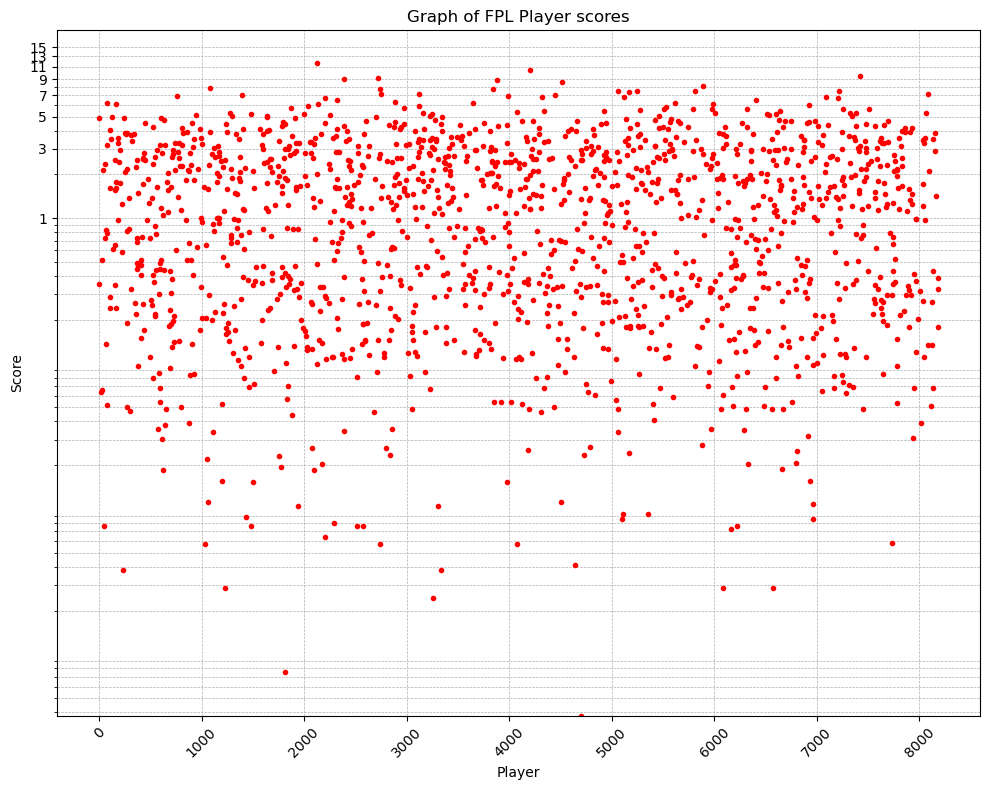

In [287]:
# Reload file to get the latest changes, it was not updating the changes otherwise
reload(util)

file_path = images_dir + "/player_score_hindcast.png"
print("Saving plot to:", file_path)

# print(df.head())

plt = util.plot_player_score_forecast("FPL Player scores", df, file_path, hindcast=False)
plt.show()

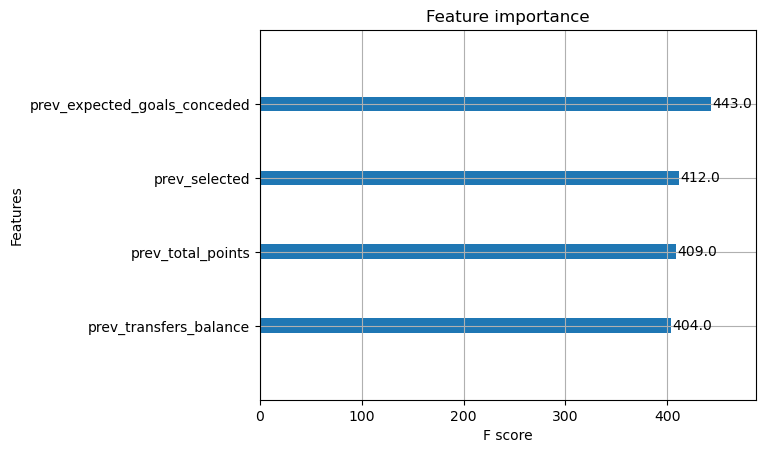

In [288]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

# Model registry

In [289]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [290]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [291]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [292]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="player_score_xgboost_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Player score predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/530192 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/110466 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18390 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/76616 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/175 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2523 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1159321/models/player_score_xgboost_model/1


Model(name: 'player_score_xgboost_model', version: 1)